# Modelos de Séries Temporais

In [155]:
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from statsforecast.utils import ConformalIntervals

In [156]:
df_raw = pl.read_csv('data/train.csv', try_parse_dates=True)

df_raw.head(5)

id,date,store_nbr,family,sales,onpromotion
i64,date,i64,str,f64,i64
0,2013-01-01,1,"""AUTOMOTIVE""",0.0,0
1,2013-01-01,1,"""BABY CARE""",0.0,0
2,2013-01-01,1,"""BEAUTY""",0.0,0
3,2013-01-01,1,"""BEVERAGES""",0.0,0
4,2013-01-01,1,"""BOOKS""",0.0,0


In [157]:
df_raw.shape

(3000888, 6)

## Preparando dataset

Vamos verificar quantas lojas temos no dataset

In [158]:
df_raw.select('store_nbr').n_unique()

54

Vamos selecionar apenas uma loja e selecionar algumas colunas para trabalhar o modelo

In [159]:
df_lj1 = (
    df_raw
    .filter(
        pl.col('store_nbr') == 1
    )
    .select(
        pl.col('date').alias('ds'),
        pl.col('family').alias('unique_id'),
        pl.col('sales').alias('y')
    )
)

print(df_lj1.shape)
df_lj1.head()

(55572, 3)


ds,unique_id,y
date,str,f64
2013-01-01,"""AUTOMOTIVE""",0.0
2013-01-01,"""BABY CARE""",0.0
2013-01-01,"""BEAUTY""",0.0
2013-01-01,"""BEVERAGES""",0.0
2013-01-01,"""BOOKS""",0.0


## Separando dados de treino e validação

In [160]:
df_train = df_lj1.filter(
    pl.col('ds') < pl.date(2014,1,1)
)

df_valid = df_lj1.filter(
    pl.col('ds').is_between(
        pl.date(2014,1,1), 
        pl.date(2014,3,31)
    )
)

h = df_valid.select(pl.col('ds')).n_unique()

Para validar o resultado do modelo vamos trabalhar com uma métrica chamada `WMAPE`` que é a média ponderada dos erros absolutos. O WMAPE é uma métrica que penaliza mais os erros grandes do que os pequenos e é muito utilizada em competições de séries temporais. Ela é calculada da seguinte forma:

$$WMAPE = \frac{\sum_{t=1}^{n} |y_t - \hat{y}_t|}{\sum_{t=1}^{n} |y_t|}$$

In [161]:
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

## Criando modelo

Vamos criar um modelo baseline para comparar com o modelo que vamos criar. O modelo baseline é um modelo que não tem nenhum conhecimento sobre os dados, ele apenas chuta o valor da última observação como o valor da próxima observação. Esse modelo é muito utilizado para comparar com modelos mais complexos e verificar se modelos mais complexos estão trazendo algum resultado.

Vamos utilizar o `Naive` do módulo `statsforecast` para criar o modelo baseline.

In [162]:
model_naive = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model_naive.fit(df_train)

StatsForecast(models=[Naive])

In [163]:
forecast_naive = model_naive.predict(h=h, level=[90])
forecast_naive = forecast_naive.select(
    pl.col('ds').cast(pl.Date).alias('ds'),
    pl.all().exclude('ds')
).join(df_valid, on=['ds', 'unique_id'])

In [164]:
metric_wmape = wmape(forecast_naive['y'].to_numpy(), forecast_naive['Naive'].to_numpy())
print(f'WMAPE Naive: {metric_wmape:.2%}')

WMAPE Naive: 57.50%


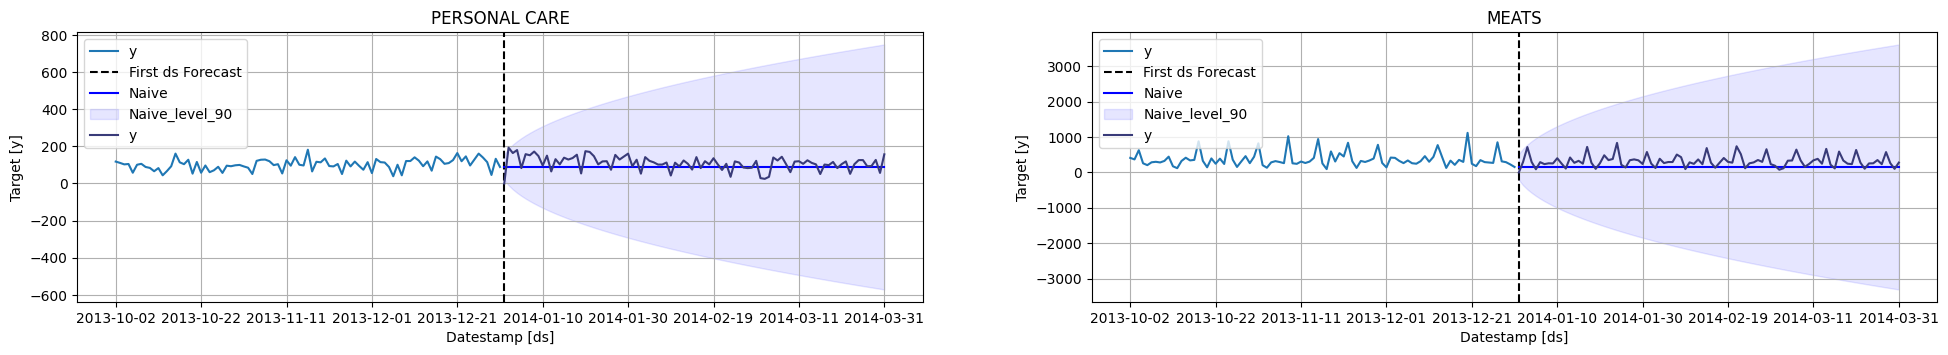

In [165]:
model_naive.plot(df_train, forecast_naive, level=[90], unique_ids = ['MEATS', 'PERSONAL CARE'], engine='matplotlib', max_insample_length=90)

### Modelo Seasonal Naive

In [166]:
model_snaive = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
model_snaive.fit(df_train)

forecast_snaive = model_snaive.predict(h=h, level=[90])
forecast_snaive = forecast_snaive.select(
    pl.col('ds').cast(pl.Date).alias('ds'),
    pl.all().exclude('ds')
).join(df_valid, on=['ds', 'unique_id'])

WMAPE SeasonalNaive: 50.91%


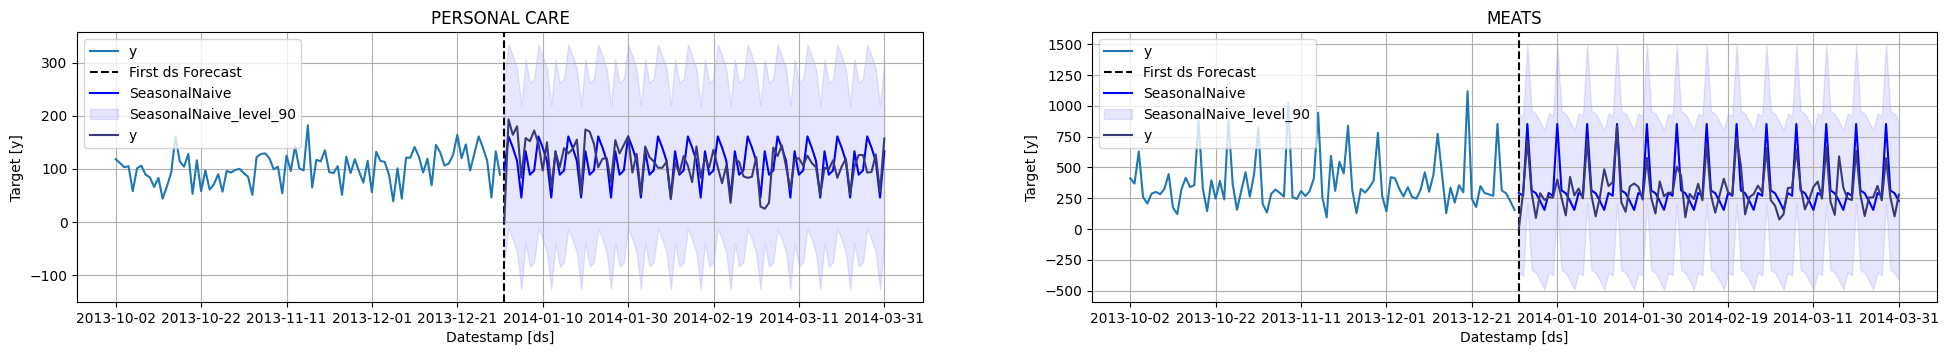

In [167]:
metric_wmape = wmape(forecast_snaive['y'].to_numpy(), forecast_snaive['SeasonalNaive'].to_numpy())
print(f'WMAPE SeasonalNaive: {metric_wmape:.2%}')
model_naive.plot(df_train, forecast_snaive, level=[90], unique_ids = ['MEATS', 'PERSONAL CARE'], engine='matplotlib', max_insample_length=90)

### SeasonalWindowAverage

In [168]:
model_swnaive = StatsForecast(models=[SeasonalWindowAverage(season_length=7, window_size=2, prediction_intervals = ConformalIntervals())], freq='D', n_jobs=-1)
model_swnaive.fit(df_train)

forecast_swnaive = model_swnaive.predict(h=h, level=[90])
forecast_swnaive = forecast_swnaive.select(
    pl.col('ds').cast(pl.Date).alias('ds'),
    pl.all().exclude('ds')
).join(df_valid, on=['ds', 'unique_id'])

WMAPE SeasonalWindowAverage: 53.02%


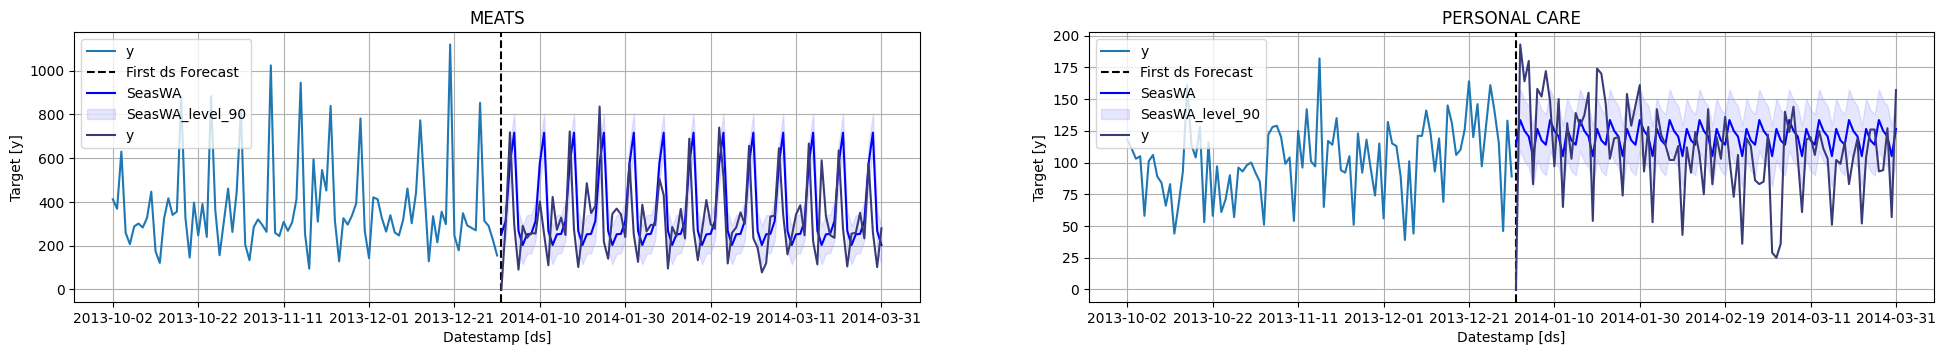

In [169]:
metric_wmape = wmape(forecast_swnaive['y'].to_numpy(), forecast_swnaive['SeasWA'].to_numpy())
print(f'WMAPE SeasonalWindowAverage: {metric_wmape:.2%}')
model_naive.plot(df_train, forecast_swnaive, level=[90], unique_ids = ['MEATS', 'PERSONAL CARE'], engine='matplotlib', max_insample_length=90)

### ARIMA

In [153]:
model_arima = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_arima.fit(df_train)

forecast_arima = model_arima.predict(h=h, level=[90])
forecast_arima = forecast_arima.select(
    pl.col('ds').cast(pl.Date).alias('ds'),
    pl.all().exclude('ds')
).join(df_valid, on=['ds', 'unique_id'])

WMAPE ARIMA: 56.78%


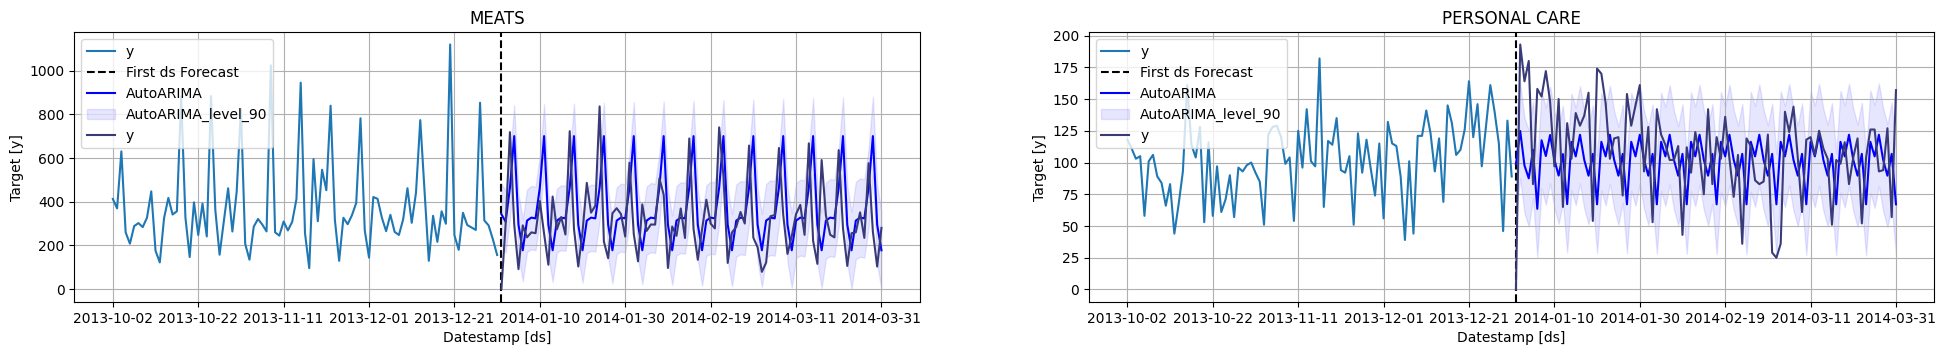

In [154]:
metric_wmape = wmape(forecast_arima['y'].to_numpy(), forecast_arima['AutoARIMA'].to_numpy())
print(f'WMAPE ARIMA: {metric_wmape:.2%}')
model_naive.plot(df_train, forecast_arima, level=[90], unique_ids = ['MEATS', 'PERSONAL CARE'], engine='matplotlib', max_insample_length=90)